# Analysis of the Temporal Evolution of Loads by Interconnection

This notebook analyzes the time series of annual total and peak loads from TELL by interconnection.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure

In [11]:
# Identify the top-level directory and the subdirectory where the data will be stored:
load_data_input_dir =  '/Users/burl878/Documents/GODEEEP/Data/Merged_BA_Loads/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/figures/'


## Process the TELL Output Files

In [15]:
# Read in the BA-to-Interconnection mapping file:
ba_mapping = pd.read_csv(data_output_dir + 'BA_to_Interconnection_Mapping.csv')

ba_mapping


,BA_Code,Interconnection
0,AEC,EIC
1,AECI,EIC
2,AVA,WECC
3,AZPS,WECC
4,BANC,WECC
5,BPAT,WECC
6,CHPD,WECC
7,CISO,WECC
8,CPLE,EIC
9,DOPD,WECC


In [8]:
years_to_process = [2025, 2030, 2035, 2050]

for i in years_to_process:
    print(i)


2025
2030
2035
2050


In [22]:
# Check to see if the processed output file exist and if not then create it:
if os.path.isfile((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv'))) == False:

   # Set the scenarios to process:
   scenarios = ['BAU_Climate', 'NetZeroNoCCS_Climate']
    
   #Initiate a counter and empty dataframe to store the results:
   counter = 0;
   output_df = pd.DataFrame()

   # Loop over the scenarios and process each time series:
   for s in range(len(scenarios)):
       years_to_process = [2025, 2030, 2035, 2050]
        
       # Loop over the years from the start_year to the end_year:
       for year in years_to_process:
           # Read in the TELL BA output file for that year and scenario:
           load_df = pd.read_csv(load_data_input_dir + 'Total_Loads_' + scenarios[s] + '_' + str(year) + '.csv')
   
           # Rename the BA variable:
           load_df.rename(columns={'BA': 'BA_Code'}, inplace=True)
             
           # Merge in the interconnection mapping using common BA codes:
           merged_df = pd.merge(load_df, ba_mapping, on='BA_Code')
            
           # Sum the BA-level hourly loads into annual interconnection-level hourly loads:
           merged_df['Interconnection_Load_MWh'] = merged_df.groupby(['Interconnection', 'Time_UTC'])['Total_Load_MWh'].transform('sum')
            
           # Only keep the columns we need and subset to the unique values:
           merged_df = merged_df[['Time_UTC', 'Interconnection', 'Interconnection_Load_MWh']].drop_duplicates()
            
           # Make a list of all of the interconnections in the 'merged_df':
           ics = merged_df['Interconnection'].unique()
         
           # Loop over the interconnections and calculate the total and peak load for each year:
           for i in range(len(ics)):
               # Iterate the counter by one:
               counter = counter + 1
            
               # Subset to just the data for the interconnection being processed:
               subset_df = merged_df[merged_df['Interconnection'].isin([ics[i]])].copy()
          
               # Put the output in a new dataframe:
               output_df.loc[counter, 'Scenario'] = scenarios[s]
               output_df.loc[counter, 'Year'] = int(year)
               output_df.loc[counter, 'Interconnection'] = ics[i]
               output_df.loc[counter, 'Total_Load_TWh'] = (subset_df['Interconnection_Load_MWh'].sum().round(6)) / 1000000
               output_df.loc[counter, 'Peak_Load_MWh'] = subset_df['Interconnection_Load_MWh'].max()
            
               # Clean up
               del subset_df

           # Clean up
           del load_df, merged_df, ics
         
   # Write out the dataframe to a .csv file:
   output_df.to_csv((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv')), sep=',', index=False)
   
else:
   # Read in the already processed output file:
   output_df = pd.read_csv((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv')))            
                  
# Preview the future dataframe:
output_df


,Scenario,Year,Interconnection,Total_Load_TWh,Peak_Load_MWh
1,BAU_Climate,2025.0,WECC,878.502269,173113.22
2,BAU_Climate,2030.0,WECC,999.319331,191701.52
3,BAU_Climate,2035.0,WECC,1078.572912,205527.52
4,BAU_Climate,2050.0,WECC,1340.645218,245925.67
5,NetZeroNoCCS_Climate,2025.0,WECC,886.972454,175082.12
6,NetZeroNoCCS_Climate,2030.0,WECC,1022.072211,196759.07
7,NetZeroNoCCS_Climate,2035.0,WECC,1074.798808,204722.87
8,NetZeroNoCCS_Climate,2050.0,WECC,2079.485884,374455.32


In [23]:
# Define a function to plot the time series of annual demand for each interconnection:
def plot_interconnection_load_time_series(data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv')))
    
    # Subset to the time series for each interconnection and scenario:
    eic_bau = output_df[output_df['Scenario'].isin(['BAU_Climate']) & output_df['Interconnection'].isin(['EIC'])]
    eic_nz = output_df[output_df['Scenario'].isin(['NetZeroNoCCS_Climate']) & output_df['Interconnection'].isin(['EIC'])]
    
    wecc_bau = output_df[output_df['Scenario'].isin(['BAU_Climate']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_nz = output_df[output_df['Scenario'].isin(['NetZeroNoCCS_Climate']) & output_df['Interconnection'].isin(['WECC'])]
        
    ercot_bau = output_df[output_df['Scenario'].isin(['BAU_Climate']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_nz = output_df[output_df['Scenario'].isin(['NetZeroNoCCS_Climate']) & output_df['Interconnection'].isin(['ERCOT'])]
        
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 14
    
    plt.subplot(231)
    plt.plot(eic_bau['Year'], eic_bau['Total_Load_TWh'], color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(eic_nz['Year'], eic_nz['Total_Load_TWh'], color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title('EIC Non-Transportation Load Projections')
    plt.title('a)', loc='left', fontsize=13)
    
    plt.subplot(232)
    plt.plot(wecc_bau['Year'], wecc_bau['Total_Load_TWh'], color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(wecc_nz['Year'], wecc_nz['Total_Load_TWh'], color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title('WECC Non-Transportation Load Projections')
    plt.title('b)', loc='left', fontsize=13)
    
    plt.subplot(233)
    plt.plot(ercot_bau['Year'], ercot_bau['Total_Load_TWh'], color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(ercot_nz['Year'], ercot_nz['Total_Load_TWh'], color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title('ERCOT Non-Transportation Load Projections')
    plt.title('c)', loc='left', fontsize=13)
    
    plt.subplot(234)
    plt.plot(eic_bau['Year'], eic_bau['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(eic_nz['Year'], eic_nz['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title('EIC Peak Demand Projections')
    plt.title('d)', loc='left', fontsize=13)
    
    plt.subplot(235)
    plt.plot(wecc_bau['Year'], wecc_bau['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(wecc_nz['Year'], wecc_nz['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title('WECC Peak Demand Projections')
    plt.title('e)', loc='left', fontsize=13)
    
    plt.subplot(236)
    plt.plot(ercot_bau['Year'], ercot_bau['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(ercot_nz['Year'], ercot_nz['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title('ERCOT Peak Demand Projections')
    plt.title('f)', loc='left', fontsize=13)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Interconnection_Load_Projections.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
       plt.close()
    

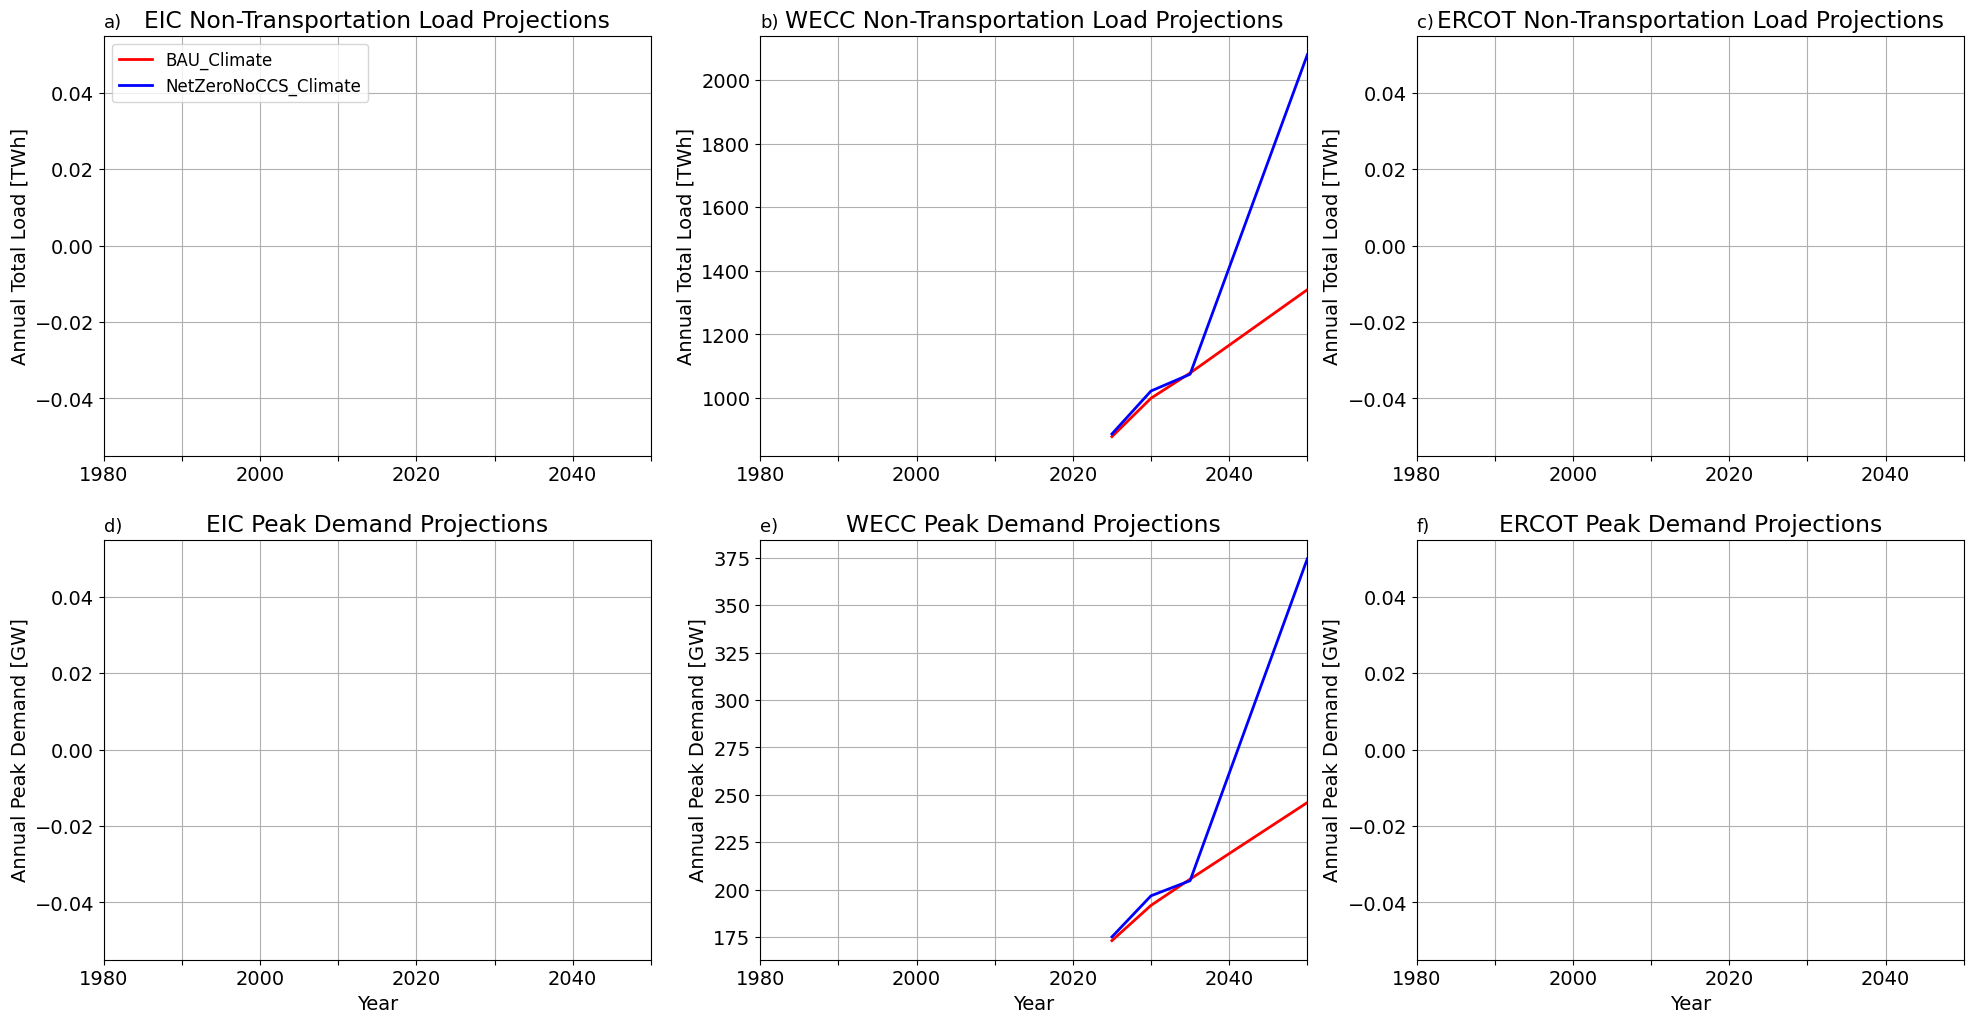

In [24]:
plot_interconnection_load_time_series(data_input_dir = data_output_dir, 
                                      image_output_dir = image_output_dir, 
                                      image_resolution = 300, 
                                      save_images = False)
